In [1]:
# Sentiment algorithm 3. Sequence of lemmas and POS-tag as multiple features input and binary sentiment classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_3'
model_variant = 'base'

training_size = 3000000
test_size = 1000000

In [2]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import os
import time
import tensorflow as tf
from keras import callbacks
from keras import Input

%reload_ext autoreload
%autoreload 2
from helpers.sentiment_functions import gender_seq_to_single
from helpers.sentiment_functions import equal_genders
from helpers.sentiment_functions import encode_feature
from helpers.sentiment_functions import plot_sentence_lengths
from helpers.sentiment_functions import plot_confusion_matrix_binary
from helpers.sentiment_functions import get_metrics
from helpers.sentiment_functions import xai_binary


pd.set_option('display.max_columns', 10, 'display.width', 10, 'display.max_colwidth', 20, 'display.max_rows',100)

In [3]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
3000000 samples are taken from the head for training
1000000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
2999995,404384,cool,cool,ADJ,0.037064,F
2999996,404384,factors,factor,NOUN,-0.055300,F
2999997,404384,like,like,ADP,-0.129606,F
2999998,404384,pore,pore,NOUN,0.000000,F


In [4]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_19240/3370681660.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_19240/3370681660.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,"[organizations, ...","[organization, d...","[NOUN, VERB, VER...",[-0.223024829414...,F
1,2,"[Women, previous...","[woman, previous...","[NOUN, ADV, VERB...",[0.2721428399909...,F
2,3,"[response, alleg...","[response, alleg...","[NOUN, NOUN, PRO...",[-0.028053754978...,F
3,4,"[aware, allegati...","[aware, allegati...","[ADJ, NOUN, PROPN]",[-0.015715441394...,F
4,5,"[point, Visa, su...","[point, Visa, su...","[NOUN, PROPN, VE...",[-0.228729956550...,F
...,...,...,...,...,...,...
362024,404378,"[Philosophy, Hel...","[philosophy, hel...","[NOUN, VERB, NOUN]","[0.0, -0.2512493...",F
362025,404379,"[Philosophy, gem...","[Philosophy, gem...","[PROPN, NOUN, AD...","[0.0, 0.0, -0.19...",F
362026,404381,"[Benefit, POREfe...","[benefit, porefe...","[VERB, NOUN, NOU...",[-0.167289610994...,F
362027,404383,[Pores],[Pores],[PROPN],[0.0],F


In [5]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,131260,"[Finally, volunt...","[finally, volunt...","[ADV, NOUN, NOUN...",[-0.005340038130...,M
1,161627,"[Cowboys, owners...","[cowboy, owner, ...","[NOUN, NOUN, VER...","[0.0, -0.1597652...",M
2,178371,"[Open, Choose, o...","[open, choose, o...","[ADJ, VERB, ADJ,...",[-0.122814094176...,M
3,191044,[relate],[relate],[VERB],[-0.071026950254...,M
4,381978,"[players, reacti...","[player, reactio...","[NOUN, NOUN, NOU...",[-0.474874235482...,M
...,...,...,...,...,...,...
362024,309272,"[biggest, misste...","[big, misstep, a...","[ADJ, NOUN, VERB...",[-0.226423977308...,M
362025,388440,"[pre, approved, ...","[pre, approve, t...","[VERB, VERB, NOU...",[-0.009007253799...,M
362026,172024,"[music, video, f...","[music, video, f...","[NOUN, NOUN, VER...",[0.0202790034356...,F
362027,270776,"[absolutely, use...","[absolutely, use...","[ADV, VERB, NOUN...",[0.0194632170854...,M


<AxesSubplot:>

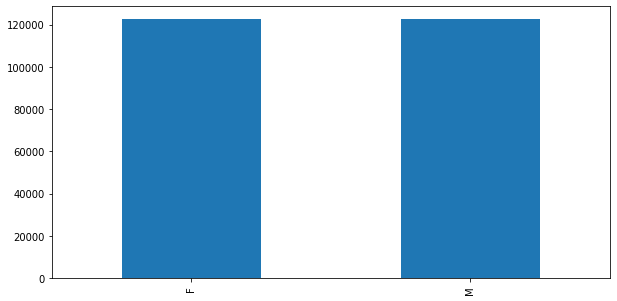

In [6]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

No handles with labels found to put in legend.


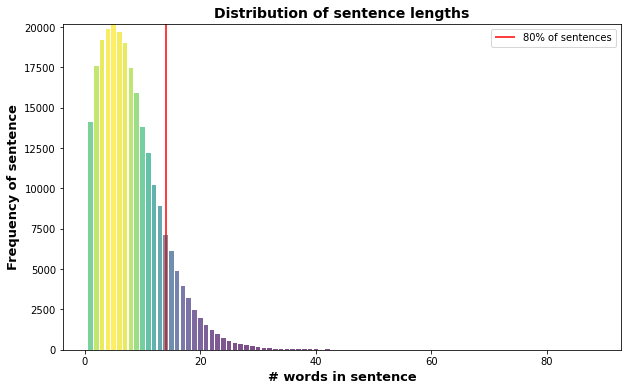

Decision boundary / 80 pct of sentence lengths is: 14


In [7]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [8]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size_lemma = encode_feature(train_data['Lemma'], test_data['Lemma'])
train_data['POS_enc'], test_data['POS_enc'], vocab_size_pos = encode_feature(train_data['POS'], test_data['POS'])

trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train_lemma = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_train_pos = pad_sequences(train_data['POS_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

X_test_lemma = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test_pos = pad_sequences(test_data['POS_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [9]:
# ONE-HOT TARGET (GENDER)
le = LabelEncoder()
le.classes_ = ['M', 'F']

y_train = le.transform(train_data['Gender'])
y_test = le.transform(test_data['Gender'])

y_train = to_categorical(y_train)

print('[M] =', le.transform(['M']), '=', to_categorical(le.transform(['M']),2))
print('[F] =', le.transform(['F']), '=', to_categorical(le.transform(['F']),2))

[M] = [0] = [[1. 0.]]
[F] = [1] = [[0. 1.]]


In [10]:
# LOADING MODEL
from tensorflow import keras
model = keras.models.load_model('saved_models/sent_algo_3/base_v2.h5')

In [11]:
# PREDICT TEST DATA
y_pred = model.predict([X_test_lemma, X_test_pos])
y_pred = y_pred.argmax(axis=-1)
y_pred = y_pred.flatten()
y_pred

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

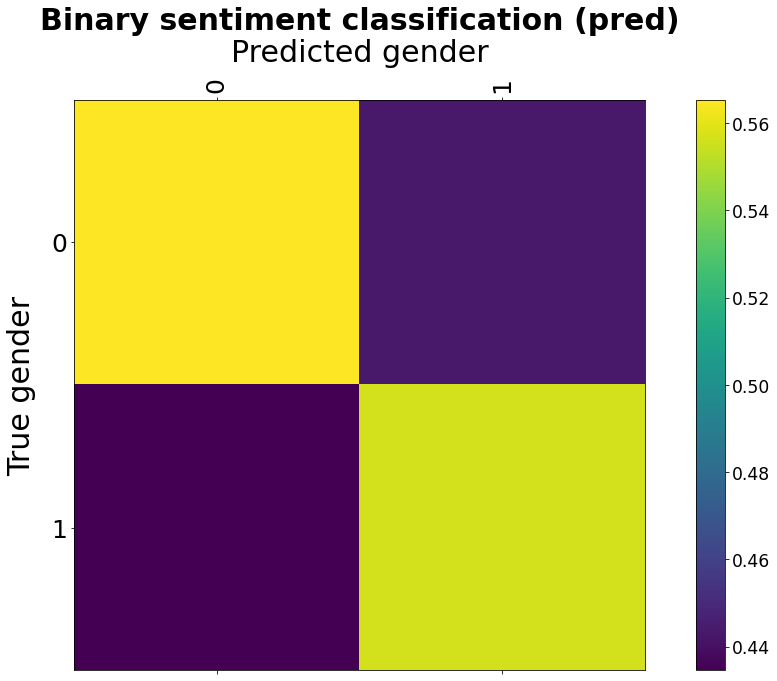

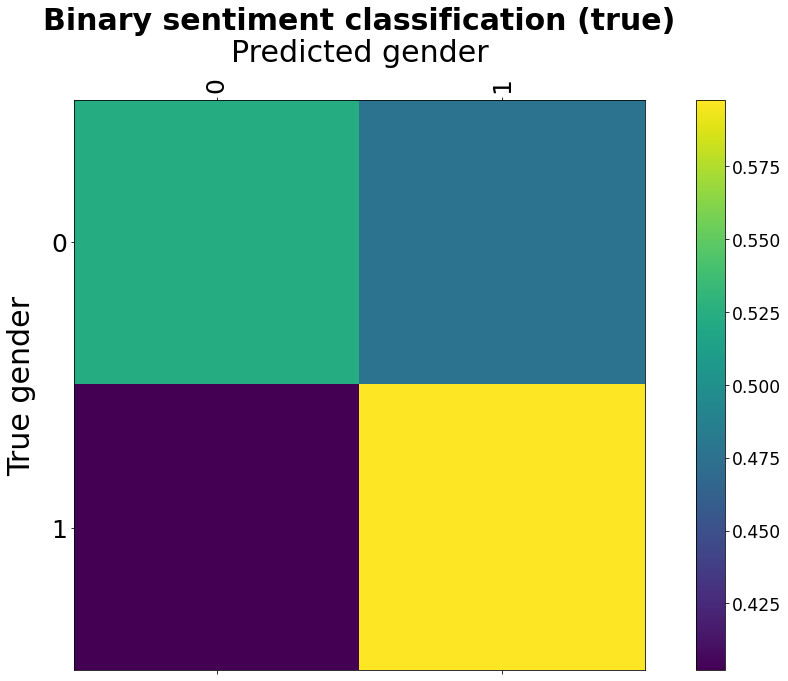

In [18]:
# PLOTTING CONFUSION MATRIX
plot_confusion_matrix_binary(np.array(y_test).flatten(), y_pred, 'Binary sentiment classification', 'Predicted gender', 'True gender')

In [13]:
# PRINTING METRICS
sentiment_vocab = ['M', 'F']
get_metrics(y_test, y_pred, sentiment_vocab, 'Gender')

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\BAC\Ezra\sentiment\models\helpers\sentiment_functions.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.57,0.52,0.54,51779.0
1,F,0.56,0.60,0.58,51779.0


In [19]:
# USE XAI ON PREDICTIONS
xai_binary(y_pred[:100], test_data, 2)


---------------------------------------------------------------------------------------
The sentence: " Some 70 percent of people over 65 will require long-term care services -- including assisted living, nursing home or home care -- during their lifetime, according to the U.S. Department of Health and Human Services.".

Was predicted to be feminine (1).

Most feminine words in sentence are:

'percent' with a polarity of 0.0
'nursing' with a polarity of 0.0

---------------------------------------------------------------------------------------
The sentence: "The February 2012 data puts us at 34%: in other words, the housing market is one-third of the way back to normal.".

Was predicted to be feminine (1).

Most feminine words in sentence are:

'normal' with a polarity of 0.02
'data' with a polarity of 0.0

---------------------------------------------------------------------------------------
The sentence: "Expecting a long wait and a large tax bill, Sonia Figueroa walked into the N